# Predictions on different data quality

## Parameters and model

In [1]:
import sys
sys.path.append('..')

from util.graphs import plot_series
from timeseries.timeseries import StockMarketSeries
from timeseries.enums import SeriesColumn, DeviationSource
from predictions.model import PredictionModel

company_name = "Facebook"
time_series_start = "2017-01-03"
time_series_values = 300
column = SeriesColumn.CLOSE
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                           weights={SeriesColumn.OPEN: 0.2,
                                    SeriesColumn.CLOSE: 0.2,
                                    SeriesColumn.ADJ_CLOSE: 0.25,
                                    SeriesColumn.HIGH: 0.15,
                                    SeriesColumn.LOW: 0.15,
                                    SeriesColumn.VOLUME: 0.05})

## Data - one price column

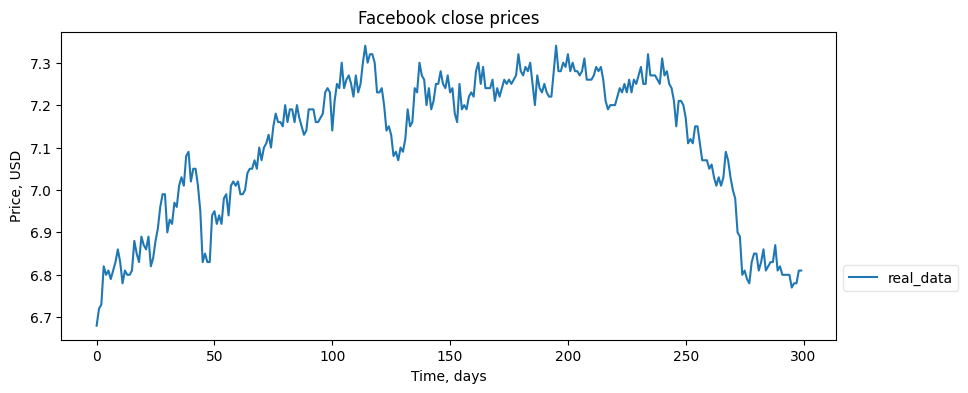

In [2]:
plot_series(stock, "close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

## Predictions parameters

In [3]:
prediction_start = 280
iterations = 5

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [4]:
from normal.arima import AutoArimaSF
from normal.statistical import Ces

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## ARIMA(p,d,q)

In [5]:
arima = model.configure_model(AutoArimaSF)

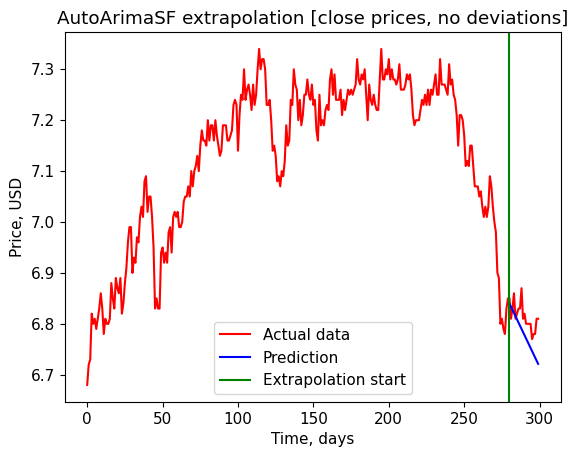

In [6]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [7]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close price, 5 iterations]

   Deviation Scale Mitigation Time [ms] Time SD M. time  RMSE   MAE   MAPE MAPE SD
0          -     -          N     65.77    6.94     0.0  0.04  0.04   0.54     0.0
1          N     S          N      70.0    9.88     0.0  0.33  0.33   4.81     0.0
2          N     S          Y     47.69   11.61   31.29  0.15  0.15   2.22     0.0
3          N     M          N    113.61    2.07     0.0  0.36  0.36   5.24     0.0
4          N     M          Y      49.2    1.64   31.28   0.4   0.4    5.8     0.0
5          N     H          N    212.86    13.3     0.0  1.16  0.97  14.22     0.0
6          N     H          Y    138.93    7.39   35.44  0.38  0.37   5.47     0.0
7          I     S          N     60.63    7.75     0.0  0.16  0.15   2.19     0.0
8          I     S          Y     69.03    8.55    0.16  0.03  0.02   0.36     0.0
9          I     M          N     70.44     8.8     0.0  0.29  0.29   4.11     0.0
10         I     M          Y  

## CES

In [8]:
ces = model.configure_model(Ces)

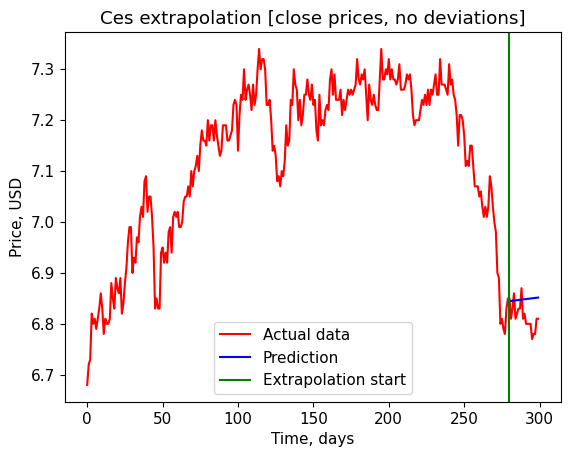

In [9]:
%%capture --no-stdout --no-display
ces.plot_prediction(source=DeviationSource.NONE)

In [10]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Facebook stock, close price, 5 iterations]

   Deviation Scale Mitigation Time [ms] Time SD M. time  RMSE   MAE  MAPE MAPE SD
0          -     -          N      6.68    8.46     0.0  0.04  0.04  0.56     0.0
1          N     S          N      9.68    8.85     0.0  0.39  0.39  5.68     0.0
2          N     S          Y      6.35    6.62   31.29  0.17  0.17  2.43     0.0
3          N     M          N     18.85    6.94     0.0  0.29  0.29  4.27     0.0
4          N     M          Y      6.25    8.56   31.28   0.4   0.4   5.8     0.0
5          N     H          N     35.62    6.76     0.0  0.07  0.07  0.99     0.0
6          N     H          Y      3.12    6.99   35.44  0.34  0.32  4.71     0.0
7          I     S          N      6.28    5.88     0.0   0.1  0.08  1.11     0.0
8          I     S          Y      6.33    7.14    0.16  0.04  0.04  0.56     0.0
9          I     M          N      6.25    8.56     0.0  0.17  0.13   1.9     0.0
10         I     M          Y      6.85   

## XGBoost

In [11]:
from normal.ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

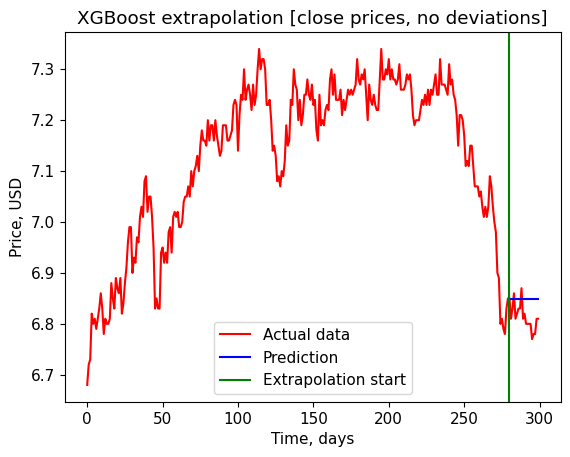

In [12]:
xgboost.plot_prediction(source=DeviationSource.NONE)

In [13]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Facebook stock, close price, 5 iterations]

   Deviation Scale Mitigation Time [ms] Time SD M. time  RMSE   MAE   MAPE MAPE SD
0          -     -          N      43.9    6.86     0.0  0.04  0.04   0.55     0.0
1          N     S          N     54.35     7.9     0.0   0.1  0.09   1.37     0.0
2          N     S          Y     47.03    8.71   31.29  0.16  0.16   2.28     0.0
3          N     M          N     67.25   13.07     0.0   1.7   1.7  24.96     0.0
4          N     M          Y     47.03    0.21   31.28   0.4   0.4    5.8     0.0
5          N     H          N     67.72    7.85     0.0  0.92  0.92  13.49     0.0
6          N     H          Y     52.05    7.29   35.44  0.53  0.52    7.7     0.0
7          I     S          N      41.8   11.28     0.0   0.1  0.07   1.05     0.0
8          I     S          Y      41.1    9.59    0.16  0.04  0.04   0.56     0.0
9          I     M          N     45.28    8.04     0.0  0.17  0.13   1.81     0.0
10         I     M          Y  

## Reservoir computing

In [14]:
from predictions.normal.ml import Reservoir

reservoir = model.configure_model(Reservoir)

In [15]:
reservoir.plot_prediction(source=DeviationSource.NONE)

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 24).

In [ ]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()